# [Kaggle] Bike Sharing Demand

[kaggle 노트북 출처](https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile)

In [35]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

## Data Description

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
          - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
          - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [18]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [19]:
print(train_df.shape)
print(test_df.shape)

(10886, 12)
(6493, 9)


In [20]:
train_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [21]:
test_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## Feature Engineering

1. Create `datetime` related columns - `month`, `date`, `hour`, `weekday`
2. Change datatype of categorical values - `season`, `holiday`, `workingday`
3. Drop the `datetime` column

In [23]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df['datetime'].min(),train_df['datetime'].max()
# from 2011-01-01 to 2012-12-19 

train_df['date'] = train_df['datetime'].dt.date
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['hour'] = train_df['datetime'].dt.hour
train_df['dayofweek'] = train_df['datetime'].dt.dayofweek

train_df.drop('datetime', axis = 1, inplace = True)

In [24]:
cat_var = ['season','weather','holiday','workingday']
for var in cat_var:
    train_df[var] = train_df[var].astype('category')

In [28]:
train_df['season'] = train_df['season'].replace(1,'spring')
train_df['season'] = train_df['season'].replace(2,'summer')
train_df['season'] = train_df['season'].replace(3,'fall')
train_df['season'] = train_df['season'].replace(4,'winter')

In [31]:
train_df['weather'] = train_df['weather'].replace(1,'clear')
train_df['weather'] = train_df['weather'].replace(2,'mist')
train_df['weather'] = train_df['weather'].replace(3,'light snow/rain')
train_df['weather'] = train_df['weather'].replace(4,'heavy snow/rain/ice')

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  date        10886 non-null  object  
 12  year        10886 non-null  int64   
 13  month       10886 non-null  int64   
 14  day         10886 non-null  int64   
 15  hour        10886 non-null  int64   
 16  dayofweek   10886 non-null  int64   
dtypes: category(4), float64(3), int64(9), object(1)
memory usage: 1.1+ MB


## Missing Value

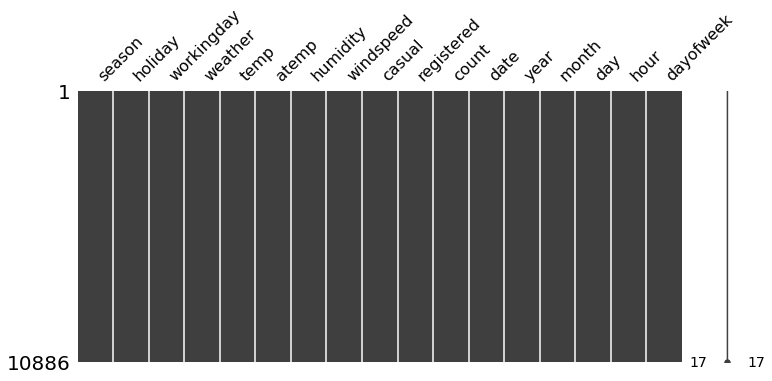

In [39]:
import missingno as msno
msno.matrix(train_df,figsize = (12,5))

# No outliers - Great

## Outlier Analysis

[Text(0, 0, 'clear'),
 Text(0, 0, 'mist'),
 Text(0, 0, 'light snow/rain'),
 Text(0, 0, 'heavy snow/rain/ice')]

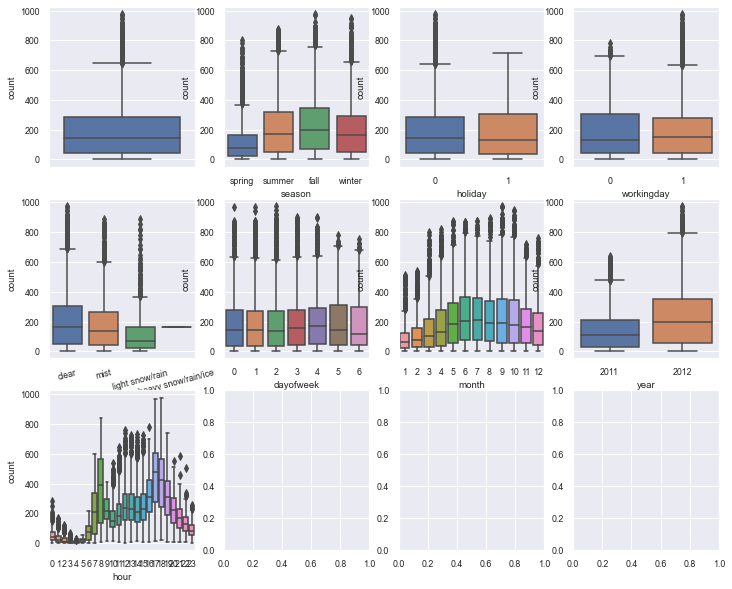

In [93]:
sns.set_style("dark")
sns.set(font_scale=0.8)

fig, axes = plt.subplots(nrows = 3, ncols = 4)
fig.set_size_inches(12,10)
sns.boxplot(y = 'count', orient = 'v', data = train_df, ax = axes[0][0])
sns.boxplot(y = 'count', x = 'season', orient = 'v', data = train_df, ax = axes[0][1])
sns.boxplot(y = 'count', x = 'holiday', orient = 'v', data = train_df, ax = axes[0][2])
sns.boxplot(y = 'count', x = 'workingday', orient = 'v', data = train_df, ax = axes[0][3])
sns.boxplot(y = 'count', x = 'weather', orient = 'v', data = train_df, ax = axes[1][0])
sns.boxplot(y = 'count', x = 'dayofweek', orient = 'v', data = train_df, ax = axes[1][1])
sns.boxplot(y = 'count', x = 'month', orient = 'v', data = train_df, ax = axes[1][2])
sns.boxplot(y = 'count', x = 'year', orient = 'v', data = train_df, ax = axes[1][3])
sns.boxplot(y = 'count', x = 'hour', orient = 'v', data = train_df, ax = axes[2][0])

axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(),rotation = 15)

1. `count` 값은 오른쪽 꼬리가 긴 그래프로 right-skewed 형태
2. `season`이 spring일 때, `count` 값이 상대적으로 낮음을 알 수 있음(median)
3. `holiday`, `workingday` 그래프를 종합해보면, workingday에 상대적으로 이상치가 많음을 알 수 있음
4. `weather` 변수중 날씨가 안좋을수록 `count`가 적어지는 추세를 볼 수 있고, 가장 날씨가 안좋은 '4' 값일 때의 그래프는 뭔가 이상함
5. `month` 그래프는 대체로 `season`과 비슷한 추세를 보임
6. `year`를 통해, 2011년보다 2012년의 `count`가 높음을 알 수 있음
7. `hour` 그래프에서 출근 시간대인 '7-8AM', '5-6PM' 시간대에 대여량이 많음을 알 수 있음

### Removing Outliers in `count`

* IQR 이상치 제거법

In [99]:
q1 = train_df['count'].quantile(.25)
q3 = train_df['count'].quantile(.75)
IQR = q3-q1
lower = q1 - 1.5*IQR
upper = q3 + 1.5*IQR
lower, upper

(-321.0, 647.0)

In [103]:
train_df_wo_outliers = train_df[(train_df['count'] >=lower) & (train_df['count']<= upper)]
train_df_wo_outliers.shape

(10586, 17)

# Evaluation Metric

In [11]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.log(y+1))
    log2 = np.nan_to_num(np.log(y_+1))
    calc = (log1 - log2)**2
    return np.sqrt(np.mean(calc))

In [12]:
submission_df = pd.read_csv('sampleSubmission.csv')
submission_df

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [13]:
rmsle(submission_df['count'].values,
     np.random.randint(0,100, size = len(submission_df)))

3.7428022394655875

In [14]:
all_df.drop('index', axis = 1, inplace = True)

In [15]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [16]:
pre_df = all_df.merge(pd.get_dummies(all_df['season'], prefix = 'season'),
                      left_index = True, right_index = True)
pre_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,season_1,season_2,season_3,season_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,0,0,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,0,0,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,0,0,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,1,0,0,0


In [17]:
pre_df = pre_df.merge(pd.get_dummies(pre_df['weather'], prefix = 'weather'),
                      left_index = True, right_index = True)
pre_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1,0,0,0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,1,0,0,0,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1,0,0,0,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1,0,0,0,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,0,0,0,0,1,0,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,0,0,0,0,1,0,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,1,0,0,0,1,0,0,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,1,0,0,0,1,0,0,0


In [18]:
train_df['datetime'] = pd.to_datetime(pre_df['datetime'])

In [19]:
pre_df['year'] = pre_df['datetime'].dt.year
pre_df['month'] = pre_df['datetime'].dt.month
pre_df['day'] = pre_df['datetime'].dt.day
pre_df['hour'] = pre_df['datetime'].dt.hour
pre_df['dayofweek'] = pre_df['datetime'].dt.dayofweek

In [20]:
pre_df = pre_df.merge(pd.get_dummies(pre_df['dayofweek'], prefix = 'dayofweek'),
                                    left_index = True, right_index = True)
pre_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,day,hour,dayofweek,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,...,1,0,5,0,0,0,0,0,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,...,1,1,5,0,0,0,0,0,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,...,1,2,5,0,0,0,0,0,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,...,1,3,5,0,0,0,0,0,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,...,1,4,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,31,19,0,1,0,0,0,0,0,0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,31,20,0,1,0,0,0,0,0,0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,...,31,21,0,1,0,0,0,0,0,0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,...,31,22,0,1,0,0,0,0,0,0


In [21]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     17379 non-null  datetime64[ns]
 1   season       17379 non-null  int64         
 2   holiday      17379 non-null  int64         
 3   workingday   17379 non-null  int64         
 4   weather      17379 non-null  int64         
 5   temp         17379 non-null  float64       
 6   atemp        17379 non-null  float64       
 7   humidity     17379 non-null  int64         
 8   windspeed    17379 non-null  float64       
 9   casual       10886 non-null  float64       
 10  registered   10886 non-null  float64       
 11  count        10886 non-null  float64       
 12  season_1     17379 non-null  uint8         
 13  season_2     17379 non-null  uint8         
 14  season_3     17379 non-null  uint8         
 15  season_4     17379 non-null  uint8         
 16  weat

In [22]:
train_en_df = pre_df.iloc[train_index]

In [23]:
len(train_en_df)

10886

KeyError: 'year'

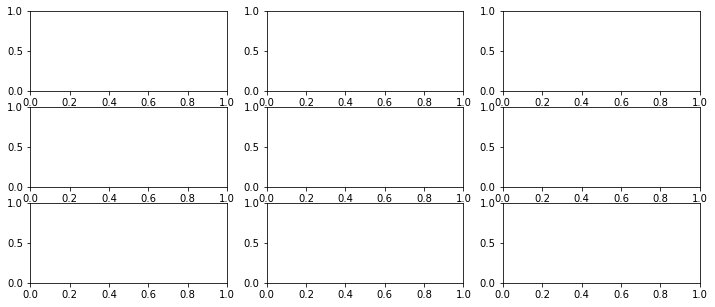

In [24]:
fig, axes = plt.subplots(nrows = 3, ncols = 3)
fig.set_size_inches(12,5)
axes[0][0].bar(train_df['year'], train_df['count'])
axes[0][1].bar(train_df['weather'], train_df['count'])
axes[0][2].bar(train_df['workingday'], train_df['count'])
axes[1][0].bar(train_df['holiday'], train_df['count'])
axes[1][1].bar(train_df['dayofweek'], train_df['count'])
axes[1][2].bar(train_df['month'], train_df['count'])
axes[2][0].bar(train_df['day'], train_df['count'])
axes[2][1].bar(train_df['hour'], train_df['count'])
plt.show()

# EDA

In [25]:
# month

label = train_df['month'].drop_duplicates().values
index = np.arange(len(label))

series_data = train_df.groupby(['month'])['count'].mean()

fig, ax = plt.subplots()
ax.bar(range(len(series_data)), series_data)
fig.set_size_inches(12,5)
plt.xlabel('month')
plt.ylabel('count')
plt.xticks(index, label, fontsize=15)
plt.show()

KeyError: 'month'

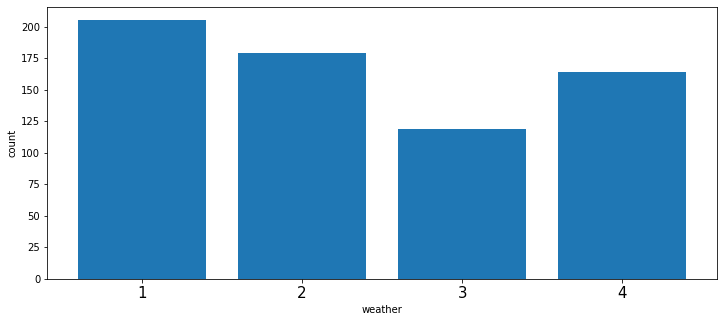

In [26]:
# weather

#- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
#- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


label = train_df['weather'].drop_duplicates().values
index = np.arange(len(label))

series_data = train_df.groupby(['weather'])['count'].mean()

fig, ax = plt.subplots()
ax.bar(range(len(series_data)), series_data)
fig.set_size_inches(12,5)
plt.xlabel('weather')
plt.ylabel('count')
plt.xticks(index, label, fontsize=15)
plt.show()

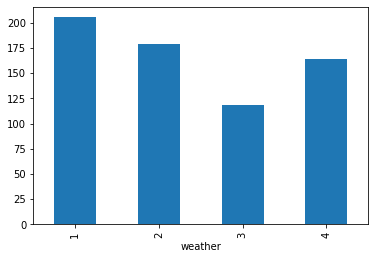

In [75]:
pre_df.groupby('weather')['count'].mean().plot.bar()

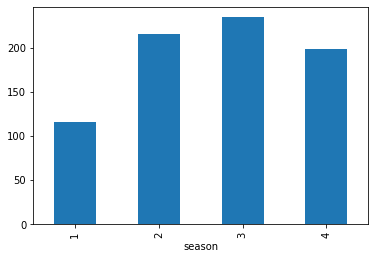

In [76]:
pre_df.groupby('season')['count'].mean().plot.bar()

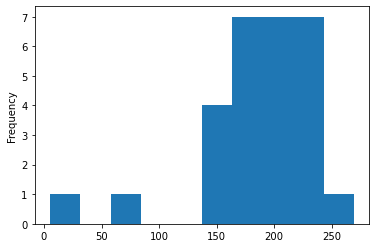

In [77]:
pre_df.groupby('windspeed')['count'].mean().plot.hist()

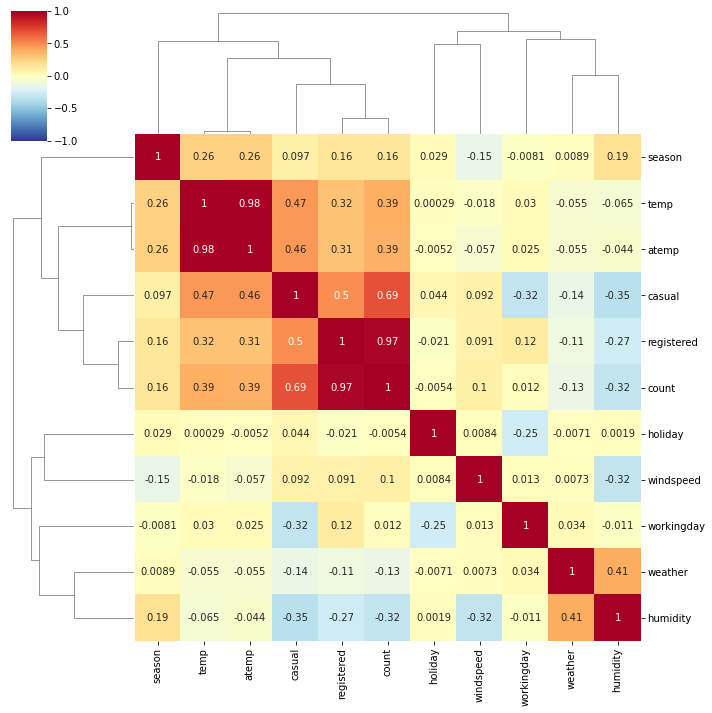

In [129]:
import seaborn as sns

sns.clustermap(train_df.corr(), 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

# temp, atemp, humidity가 타겟변수와 가장 상관관계 높은 편

In [105]:
train_df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,day,hour,dayofweek,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,...,0.001729,-0.006546,-0.010553,0.019600,0.001729,-0.008655,-0.009595,0.000092,-0.002445,-0.000688
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,...,-0.015877,-0.000354,-0.191832,0.307134,-0.069586,-0.032041,-0.069954,0.006853,-0.070767,-0.070636
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,...,0.009829,0.002780,-0.704267,0.144311,0.277799,0.265528,0.279269,0.249523,-0.602757,-0.601643
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,...,-0.007890,-0.022740,-0.047692,-0.012846,0.059088,0.053497,-0.026033,-0.032025,-0.015943,-0.025393
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,...,0.015551,0.145430,-0.038466,0.020387,0.026116,0.004842,0.001098,-0.012331,-0.029779,-0.009986
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,...,0.011866,0.140343,-0.040235,0.025177,0.028625,0.005252,-0.000656,-0.028071,-0.025995,-0.004147
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,...,-0.011335,-0.278011,-0.026507,0.013166,0.037454,0.051104,-0.073946,-0.041454,-0.013580,0.027087
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,...,0.036157,0.146631,-0.024804,0.006106,0.026811,-0.008189,0.016922,-0.019848,-0.006533,-0.015138
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,...,0.014109,0.302045,0.246959,-0.050407,-0.105937,-0.110151,-0.098104,-0.040619,0.228003,0.173383
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,...,0.019111,0.380540,-0.084427,0.013480,0.030070,0.027900,0.047905,0.030218,-0.061508,-0.086626
